# LDA

In [1]:
# Standard Library & Utilities
!pip install torch_xla
!pip install cloud-tpu-client
import time
import pickle
from itertools import product, combinations
import torch
import torch_xla.core.xla_model as xm

# Data Manipulation & Numerics
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction & Clustering
!pip install umap-learn # Install umap-learn
!pip install hdbscan # Install hdbscan
from umap import UMAP
from hdbscan import HDBSCAN

# Scikit-Learn (Feature Extraction & Modelling)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLP - Gensim
!pip install gensim # Install gensim
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon

# NLP - NLTK
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet

# NLP - BERTopic & Transformers
!pip install bertopic # Install bertopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline

/usr/local/lib/python3.12/dist-packages/torch_xla/__init__.py:246: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# df_docs = pd.read_csv("data_cleaned/dostoevsky_chunks.csv")
df_docs = pd.read_csv("/content/drive/MyDrive/wne_uw/3/project/text_mining_final/text_mining_topic_modelling/data_cleaned/dostoevsky_chunks.csv")
df_docs.head(4)
df_docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   book_id      4787 non-null   object
 1   chunk_index  4787 non-null   int64 
 2   chunk_id     4787 non-null   object
 3   text_base    4787 non-null   object
 4   text_lda     4787 non-null   object
 5   text_bert    4787 non-null   object
dtypes: int64(1), object(5)
memory usage: 224.5+ KB


In [4]:
vectorizer = CountVectorizer(
    min_df=15,        # adjust later if vocab too small/large
    max_df=0.95
)

dtm = vectorizer.fit_transform(df_docs["text_lda"])
vocab = vectorizer.get_feature_names_out()

print("dtm shape:", dtm.shape)   # (n_docs, n_terms)

dtm shape: (4787, 4247)


In [5]:
print("n_docs:", dtm.shape[0])
print("vocab_size:", dtm.shape[1])

n_docs: 4787
vocab_size: 4247


In [6]:
k = 20
lda = LatentDirichletAllocation(
    n_components=k,
    random_state=1881
)

doc_topic = lda.fit_transform(dtm)  # shape: (n_docs, k)

In [7]:
def show_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_ids = np.argsort(topic)[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_ids]
        topics.append((topic_idx, top_words))
    return topics

topics = show_topics(lda, vocab, n_top_words=10)
for tid, words in topics:
    print(f"topic {tid}: {', '.join(words)}")

topic 0: think, speak, laugh, face, understand, question, right, yes, something, ask
topic 1: begin, moment, hand, answer, ilyitch, ask, without, suddenly, cry, head
topic 2: think, get, good, yes, razumihin, want, ask, dounia, petrovitch, take
topic 3: prince, lebedeff, gania, think, rogojin, quite, nastasia, much, word, evgenie
topic 4: stepanovitch, liputin, nothing, think, day, virginsky, erkel, give, without, get
topic 5: day, petrovna, take, vsyevolodovitch, trofimovitch, stepanovitch, town, petersburg, year, first
topic 6: every, church, society, people, question, begin, russian, verhovensky, yulia, mihailovna
topic 7: child, gentleman, take, dance, mavriky, girl, people, get, nikolaevitch, little
topic 8: young, lady, old, two, upon, year, room, stake, family, people
topic 9: hand, suddenly, room, face, eye, stand, away, take, begin, head
topic 10: love, think, heart, good, life, never, day, dear, perhaps, little
topic 11: father, elder, monk, day, monastery, zossima, many, gre

In [8]:
lda_topic_cols = [f"topic_{i}" for i in range(k)]
lda_df_topic = pd.DataFrame(doc_topic, columns=lda_topic_cols)
lda_df_topic["book_id"] = df_docs["book_id"].values

lda_book_topic = lda_df_topic.groupby("book_id")[lda_topic_cols].mean()

# most prominent topic per book
top_topic = lda_book_topic.idxmax(axis=1)

print("most prominent topic per book:")
print(top_topic)

lda_book_topic

most prominent topic per book:
book_id
Crime_and_Punishment               topic_2
Notes_from_the_Underground        topic_17
Poor_Folk                         topic_19
Short_Stories                      topic_9
The_Brothers_Karamazov             topic_9
The_Gambler                       topic_19
The_Grand_Inquisitor              topic_13
The_Idiot                          topic_3
The_Possessed _or_The_Devils       topic_5
White_Nights_and_Other_Stories     topic_9
dtype: object


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
book_id,,,,,,,,,,,,,,,,,,,,
Crime_and_Punishment,0.012922,0.028046,0.315247,0.001389,0.010934,0.033363,0.008698,0.028362,0.031349,0.263436,0.064815,0.006711,0.025244,0.014557,0.009276,0.017689,0.006819,0.070860,0.041519,0.008764
Notes_from_the_Underground,0.034079,0.091297,0.062005,0.002486,0.024780,0.012839,0.010271,0.055755,0.044884,0.158756,0.087554,0.020395,0.009552,0.014306,0.019137,0.008723,0.000425,0.294920,0.029040,0.018797
Poor_Folk,0.005424,0.011513,0.008381,0.004466,0.005650,0.015666,0.003571,0.006735,0.051984,0.121845,0.291895,0.011144,0.003811,0.018000,0.006728,0.013207,0.000405,0.023440,0.026561,0.369574
Short_Stories,0.014734,0.102423,0.060816,0.001451,0.008684,0.048613,0.017843,0.077702,0.061907,0.198692,0.071428,0.021908,0.047940,0.022007,0.012273,0.011055,0.013030,0.072926,0.118397,0.016172
The_Brothers_Karamazov,0.013090,0.032282,0.038468,0.001831,0.002075,0.020038,0.019882,0.020364,0.038808,0.156189,0.130660,0.070277,0.101881,0.060910,0.117863,0.041161,0.019506,0.056142,0.053920,0.004652
The_Gambler,0.025252,0.006790,0.015442,0.011492,0.007783,0.009219,0.004505,0.008361,0.160859,0.065419,0.049392,0.004086,0.003908,0.005333,0.004132,0.016165,0.011540,0.044872,0.034586,0.510865
The_Grand_Inquisitor,0.018989,0.006729,0.008018,0.001858,0.002762,0.000374,0.000915,0.004386,0.025509,0.059950,0.015080,0.011359,0.013907,0.765697,0.005954,0.000374,0.001019,0.049276,0.004530,0.003314
The_Idiot,0.042531,0.024213,0.016948,0.408546,0.005182,0.016761,0.009753,0.014386,0.053645,0.098066,0.084362,0.007253,0.010786,0.012177,0.007767,0.093043,0.021404,0.042468,0.021326,0.009382
The_Possessed _or_The_Devils,0.023433,0.032054,0.075868,0.002698,0.057370,0.168042,0.087829,0.038896,0.043924,0.132462,0.067959,0.011600,0.013739,0.015093,0.019151,0.016965,0.106749,0.058487,0.022062,0.005621


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(lda_book_topic.values)
lda_book_sim = pd.DataFrame(sim, index=lda_book_topic.index, columns=lda_book_topic.index)

lda_book_sim

book_id,Crime_and_Punishment,Notes_from_the_Underground,Poor_Folk,Short_Stories,The_Brothers_Karamazov,The_Gambler,The_Grand_Inquisitor,The_Idiot,The_Possessed _or_The_Devils,White_Nights_and_Other_Stories
book_id,,,,,,,,,,
Crime_and_Punishment,1.000000,0.599190,0.298761,0.735590,0.608148,0.175419,0.108716,0.246163,0.630794,0.741262
Notes_from_the_Underground,0.599190,1.000000,0.352104,0.745073,0.623024,0.240708,0.138748,0.278482,0.563708,0.823134
Poor_Folk,0.298761,0.352104,1.000000,0.418030,0.470143,0.828321,0.078750,0.221523,0.326431,0.574597
Short_Stories,0.735590,0.745073,0.418030,1.000000,0.788111,0.274190,0.161989,0.316834,0.712876,0.860025
The_Brothers_Karamazov,0.608148,0.623024,0.470143,0.788111,1.000000,0.207882,0.288016,0.323496,0.613889,0.797160
The_Gambler,0.175419,0.240708,0.828321,0.274190,0.207882,1.000000,0.042250,0.143143,0.195640,0.275630
The_Grand_Inquisitor,0.108716,0.138748,0.078750,0.161989,0.288016,0.042250,1.000000,0.064594,0.117345,0.123312
The_Idiot,0.246163,0.278482,0.221523,0.316834,0.323496,0.143143,0.064594,1.000000,0.278142,0.351497
The_Possessed _or_The_Devils,0.630794,0.563708,0.326431,0.712876,0.613889,0.195640,0.117345,0.278142,1.000000,0.660505


In [10]:
threshold = 0.05  # tweak if needed

topic_breadth = (lda_book_topic > threshold).sum(axis=0)  # count of books per topic
topic_breadth_pct = topic_breadth / lda_book_topic.shape[0]

lda_recurrence = pd.DataFrame({
    "topic": topic_breadth.index,
    "n_books": topic_breadth.values,
    "pct_books": topic_breadth_pct.values
}).sort_values("n_books", ascending=False)

print("Topic recurrence across books (threshold =", threshold, "):")
print(lda_recurrence)

# optional: show top 5 most recurrent topics
print("\nTop 5 most recurrent topics:")
print(lda_recurrence.head(5))

Topic recurrence across books (threshold = 0.05 ):
       topic  n_books  pct_books
9    topic_9       10        1.0
10  topic_10        8        0.8
17  topic_17        6        0.6
2    topic_2        5        0.5
8    topic_8        5        0.5
1    topic_1        3        0.3
19  topic_19        2        0.2
18  topic_18        2        0.2
13  topic_13        2        0.2
7    topic_7        2        0.2
11  topic_11        1        0.1
3    topic_3        1        0.1
15  topic_15        1        0.1
4    topic_4        1        0.1
5    topic_5        1        0.1
6    topic_6        1        0.1
12  topic_12        1        0.1
14  topic_14        1        0.1
16  topic_16        1        0.1
0    topic_0        0        0.0

Top 5 most recurrent topics:
       topic  n_books  pct_books
9    topic_9       10        1.0
10  topic_10        8        0.8
17  topic_17        6        0.6
2    topic_2        5        0.5
8    topic_8        5        0.5


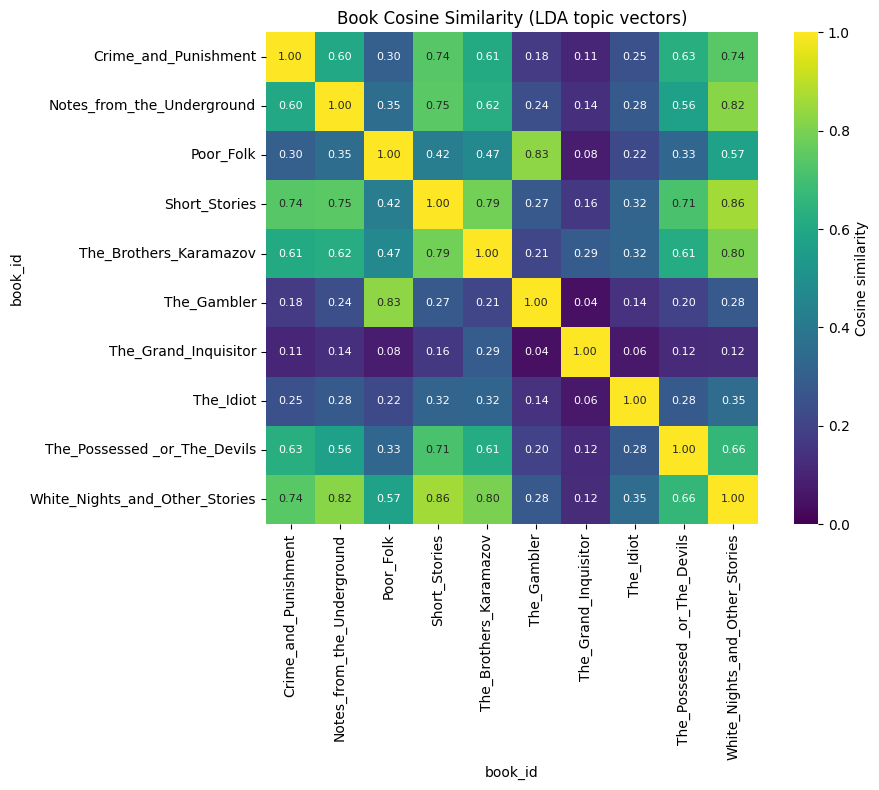

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    lda_book_sim,
    cmap="viridis",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cosine similarity"},
    annot=True,        # Display numbers in each cell
    fmt=".2f",         # Format numbers to two decimal places
    annot_kws={"size": 8} # Adjust font size of annotations
)
plt.title("Book Cosine Similarity (LDA topic vectors)")
plt.xlabel("book_id")
plt.ylabel("book_id")
plt.tight_layout()
plt.show()

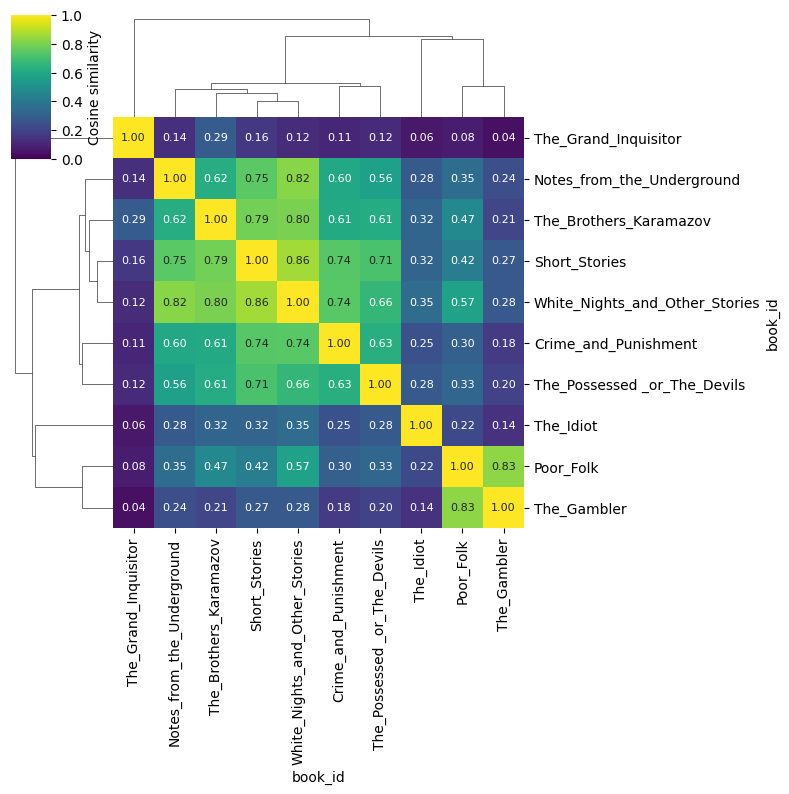

In [31]:
sns.clustermap(
    lda_book_sim,
    cmap="viridis",
    vmin=0, vmax=1,
    figsize=(8, 8),
    cbar_kws={"label": "Cosine similarity"},
    metric="euclidean",   # clustering on similarity matrix itself
    method="average",
    annot=True,        # Display numbers in each cell
    fmt=".2f",         # Format numbers to two decimal places
    annot_kws={"size": 8} # Adjust font size of annotations
)

In [13]:
# -------------------------------
# LDA: per-topic coherence (NPMI / UCI / UMass)
# -------------------------------

import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# 1) Tokenise using the SAME analyzer as CountVectorizer
lda_analyzer = vectorizer.build_analyzer()
lda_texts = df_docs["text_lda"].astype(str).tolist()
lda_tokens = [lda_analyzer(t) for t in lda_texts]

# 2) Gensim dictionary/corpus
lda_dictionary = Dictionary(lda_tokens)
lda_corpus = [lda_dictionary.doc2bow(toks) for toks in lda_tokens]

# 3) Extract top words per topic from sklearn LDA
def lda_top_words(lda_model, vocab, topn=10):
    topic_words = []
    for k in range(lda_model.components_.shape[0]):
        comp = lda_model.components_[k]
        top_ids = np.argsort(comp)[::-1][:topn]
        topic_words.append([vocab[i] for i in top_ids])
    return topic_words

lda_topic_words_10 = lda_top_words(lda, vocab, topn=10)

# 4) Coherence per topic
coh_npmi = CoherenceModel(topics=lda_topic_words_10, texts=lda_tokens,
                          dictionary=lda_dictionary, coherence="c_npmi")
coh_uci  = CoherenceModel(topics=lda_topic_words_10, texts=lda_tokens,
                          dictionary=lda_dictionary, coherence="c_uci")
coh_umass = CoherenceModel(topics=lda_topic_words_10, corpus=lda_corpus,
                           dictionary=lda_dictionary, coherence="u_mass")

lda_quality = pd.DataFrame({
    "topic_id": range(len(lda_topic_words_10)),
    "coh_npmi": coh_npmi.get_coherence_per_topic(),
    "coh_uci": coh_uci.get_coherence_per_topic(),
    "coh_umass": coh_umass.get_coherence_per_topic(),
    "top_words": [", ".join(ws) for ws in lda_topic_words_10]
}).sort_values("coh_npmi", ascending=False)

lda_quality.head(10)


,topic_id,coh_npmi,coh_uci,coh_umass,top_words
13,13,0.159922,1.369854,-1.907274,"god, thou, earth, men, world, great, thee, sin..."
18,18,0.128004,0.819519,-0.957955,"rouble, money, thousand, give, hundred, three,..."
11,11,0.105950,0.861103,-1.643062,"father, elder, monk, day, monastery, zossima, ..."
3,3,0.089500,0.692908,-1.482198,"prince, lebedeff, gania, think, rogojin, quite..."
12,12,0.079717,0.676331,-1.602638,"murder, doctor, evidence, kill, prosecutor, pr..."
5,5,0.047087,0.386205,-1.665049,"day, petrovna, take, vsyevolodovitch, trofimov..."
4,4,0.036553,0.307332,-1.504758,"stepanovitch, liputin, nothing, think, day, vi..."
2,2,0.036227,0.278631,-1.697752,"think, get, good, yes, razumihin, want, ask, d..."
16,16,0.034041,-0.068700,-1.628716,"trofimovitch, petrovna, room, sit, house, sudd..."
9,9,0.031115,0.198272,-1.057625,"hand, suddenly, room, face, eye, stand, away, ..."


In [14]:
lda_avg = lda_quality[["coh_umass", "coh_uci", "coh_npmi"]].mean()
print("LDA average coherence scores:")
print(lda_avg)

LDA average coherence scores:
coh_umass   -1.674288
coh_uci      0.128767
coh_npmi     0.040347
dtype: float64


In [15]:
def topic_diversity(topic_words, topn=10):
    words = [w for topic in topic_words for w in topic[:topn]]
    return len(set(words)) / (len(topic_words) * topn)

lda_diversity_10 = topic_diversity(lda_topic_words_10, topn=10)
print("LDA topic diversity for top 10 words:", lda_diversity_10)

LDA topic diversity for top 10 words: 0.645


In [16]:
# -------------------------------
# LDA: topic redundancy via Jensen–Shannon distance
# -------------------------------

# Topic-word distributions phi_k(w)
lda_phi = lda.components_.astype(float)
lda_phi = lda_phi / lda_phi.sum(axis=1, keepdims=True)

K = lda_phi.shape[0]
lda_jsd = np.zeros((K, K))
for i in range(K):
    for j in range(K):
        lda_jsd[i, j] = jensenshannon(lda_phi[i], lda_phi[j])  # distance in [0, 1]

lda_jsd_df = pd.DataFrame(
    lda_jsd,
    index=[f"topic_{i}" for i in range(K)],
    columns=[f"topic_{i}" for i in range(K)]
)

# Top redundant topic pairs = smallest off-diagonal distances
pairs = []
for i in range(K):
    for j in range(i+1, K):
        pairs.append((i, j, lda_jsd[i, j]))
pairs.sort(key=lambda x: x[2])

print("Most similar (potentially redundant) LDA topic pairs (smallest JSD distance):")
for i, j, d in pairs[:10]:
    print(f"topic_{i} vs topic_{j}: JSD={d:.4f}")


Most similar (potentially redundant) LDA topic pairs (smallest JSD distance):
topic_2 vs topic_9: JSD=0.4514
topic_9 vs topic_15: JSD=0.4576
topic_9 vs topic_16: JSD=0.4618
topic_2 vs topic_10: JSD=0.4655
topic_1 vs topic_9: JSD=0.4659
topic_1 vs topic_2: JSD=0.4688
topic_2 vs topic_15: JSD=0.4712
topic_10 vs topic_14: JSD=0.4768
topic_2 vs topic_3: JSD=0.4862
topic_10 vs topic_17: JSD=0.4877


# BERT

In [17]:
from sentence_transformers import SentenceTransformer
import torch
import torch_xla.core.xla_model as xm
import os # Import the os module

# 0) Texts for BERTopic
texts = df_docs["text_bert"].astype(str).tolist()

# 1) Stopwords (English + your extras)
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
stop_words |= {
    "said","say","tell","would","could","must","shall","one","though","even","well","like",
    "know","come","look","see","go","make","man","time"
}

# 2) Embeddings (light + good for English, TPU/GPU fallback)
# To use GPU/TPU, ensure your Colab runtime type is set accordingly

device = "cpu"
try:
    # Try TPU first
    if 'COLAB_TPU_ADDR' in os.environ:
        device = xm.xla_device()
        print("Using device: TPU")
    elif torch.cuda.is_available():
        device = "cuda"
        print("Using device: GPU")
        print("GPU Name:", torch.cuda.get_device_name(0))
    else:
        print("Using device: CPU")
except Exception as e:
    print(f"Could not detect accelerator, falling back to CPU. Error: {e}")
    print("Using device: CPU")

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
embedding_model.max_seq_length = 512  # avoid >512 warnings

# 3) UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
    min_dist=0.05,
    random_state=42
)

# 4) HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# 5) Vectorizer
tokenizer = RegexpTokenizer(r"\w+")
tf_vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    min_df=15,  # Aligned with LDA
    max_df=0.95, # Aligned with LDA
    tokenizer=tokenizer.tokenize,
    stop_words=list(stop_words)
)

# 6) Topic representation
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

# 7) BERTopic
topic_model_bert = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=tf_vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    top_n_words=10,
    calculate_probabilities=True,
    nr_topics=20  # Set to 20 for consistency with LDA
)

topics, probabilities = topic_model_bert.fit_transform(texts)

# Inspect summary
topic_model_bert.get_topic_info()

Using device: GPU
GPU Name: Tesla T4


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1658,-1_mind_words_thought_moment,"[mind, words, thought, moment, suddenly, fathe...",[and soft. he saw that she too had come to him...
1,0,1736,0_suddenly_words_moment_came,"[suddenly, words, moment, came, took, turned, ...","[straight before him, he could see him and was..."
2,1,366,1_words_laughing_suddenly_much,"[words, laughing, suddenly, much, came, laughe...","[by ten or twenty times, if you like. there, t..."
3,2,290,2_feel_suddenly_word_thought,"[feel, suddenly, word, thought, moment, upon, ...",[hearse. at the corner of the street he was jo...
4,3,206,3_father_death_tears_words,"[father, death, tears, words, feel, seemed, gi...","[follow the christian ideal, for hitherto neit..."
5,4,189,4_words_much_keep_tears,"[words, much, keep, tears, course, laughed, la...","[life. curse it, curse it, curse those five ye..."
6,5,83,5_father_death_words_moment,"[father, death, words, moment, word, thought, ...","[statement, with the obvious motive of ruining..."
7,6,80,6_life_mind_understand_become,"[life, mind, understand, become, think, ought,...",[calculated and explained that there will be n...
8,7,39,7_happened_laughed_came_moment,"[happened, laughed, came, moment, father, moth...","[pot, it burned splendidly, it all burnt away ..."
9,8,39,8_words_without_much_speak,"[words, without, much, speak, word, believe, s...","[relied upon, and scarcely survived the emanci..."


In [18]:
# topic summary + top words
topic_info = topic_model_bert.get_topic_info()
topic_info.head(10)

# print top words per topic
for tid in topic_info.Topic[topic_info.Topic != -1]:
    words = [w for w, _ in topic_model_bert.get_topic(tid)]
    print(f"topic {tid}: {', '.join(words[:10])}")

topic 0: suddenly, words, moment, came, took, turned, seemed, course, get, later
topic 1: words, laughing, suddenly, much, came, laughed, speak, moment, mother, something
topic 2: feel, suddenly, word, thought, moment, upon, mind, tears, much, came
topic 3: father, death, tears, words, feel, seemed, given, mother, upon, thought
topic 4: words, much, keep, tears, course, laughed, laugh, mind, laughing, enough
topic 5: father, death, words, moment, word, thought, case, ought, another, took
topic 6: life, mind, understand, become, think, ought, reason, matter, things, upon
topic 7: happened, laughed, came, moment, father, mother, another, kept, little, suddenly
topic 8: words, without, much, speak, word, believe, speaking, simply, understand, enough
topic 9: turn, seemed, get, give, full, turned, much, kept, laugh, little
topic 10: mother, laughed, tears, death, words, seemed, laugh, happened, word, kept
topic 11: upon, although, word, father, words, else, thinking, speaking, speak, ought

In [19]:
# document-level assignments
df_assign = pd.DataFrame({
    "book_id": df_docs["book_id"].values,
    "topic_id": np.asarray(topics)
})

# drop outliers
df_assign = df_assign[df_assign["topic_id"] != -1].copy()

# book-topic distribution (rows sum to 1)
bert_book_topic = (
    pd.crosstab(df_assign["book_id"], df_assign["topic_id"], normalize="index")
    .sort_index(axis=1)
)

# rename columns to match LDA style: topic_{id}
bert_book_topic.columns = [f"topic_{t}" for t in bert_book_topic.columns]

# most prominent topic per book (same as LDA)
top_topic = bert_book_topic.idxmax(axis=1)

print("most prominent topic per book:")
print(top_topic)

bert_book_topic

most prominent topic per book:
book_id
Crime_and_Punishment              topic_0
Notes_from_the_Underground        topic_2
Poor_Folk                         topic_2
Short_Stories                     topic_0
The_Brothers_Karamazov            topic_0
The_Gambler                       topic_0
The_Grand_Inquisitor              topic_3
The_Idiot                         topic_1
The_Possessed _or_The_Devils      topic_0
White_Nights_and_Other_Stories    topic_0
dtype: object


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
book_id,,,,,,,,,,,,,,,,,,,
Crime_and_Punishment,0.943231,0.000000,0.008734,0.008734,0.000000,0.010917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010917,0.010917,0.000000,0.000000,0.000000,0.000000,0.00655
Notes_from_the_Underground,0.183486,0.000000,0.431193,0.009174,0.000000,0.000000,0.284404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036697,0.027523,0.018349,0.009174,0.00000
Poor_Folk,0.150442,0.000000,0.743363,0.008850,0.000000,0.000000,0.044248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044248,0.008850,0.000000,0.000000,0.000000,0.00000
Short_Stories,0.802885,0.000000,0.129808,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009615,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
The_Brothers_Karamazov,0.367801,0.000000,0.018325,0.202880,0.243455,0.096859,0.005236,0.051047,0.002618,0.000000,0.001309,0.010471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
The_Gambler,0.695035,0.000000,0.099291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
The_Grand_Inquisitor,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
The_Idiot,0.096567,0.785408,0.042918,0.008584,0.004292,0.006438,0.019313,0.000000,0.008584,0.000000,0.019313,0.008584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
The_Possessed _or_The_Devils,0.920152,0.000000,0.009506,0.005703,0.001901,0.000000,0.000000,0.000000,0.062738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

bert_book_sim = cosine_similarity(bert_book_topic.values)
bert_book_sim = pd.DataFrame(bert_book_sim, index=bert_book_topic.index, columns=bert_book_topic.index)
bert_book_sim

book_id,Crime_and_Punishment,Notes_from_the_Underground,Poor_Folk,Short_Stories,The_Brothers_Karamazov,The_Gambler,The_Grand_Inquisitor,The_Idiot,The_Possessed _or_The_Devils,White_Nights_and_Other_Stories
book_id,,,,,,,,,,
Crime_and_Punishment,1.000000,0.340588,0.207420,0.986597,0.744429,0.950986,0.009256,0.122410,0.997452,0.923733
Notes_from_the_Underground,0.340588,1.000000,0.861838,0.454030,0.287091,0.422928,0.016664,0.095721,0.340665,0.667327
Poor_Folk,0.207420,0.861838,1.000000,0.350928,0.187205,0.320335,0.011627,0.078458,0.207326,0.541911
Short_Stories,0.986597,0.454030,0.350928,1.000000,0.761627,0.957036,0.070752,0.129263,0.984363,0.963735
The_Brothers_Karamazov,0.744429,0.287091,0.187205,0.761627,1.000000,0.706394,0.407247,0.101115,0.740796,0.695267
The_Gambler,0.950986,0.422928,0.320335,0.957036,0.706394,1.000000,0.000000,0.123013,0.949152,0.923155
The_Grand_Inquisitor,0.009256,0.016664,0.011627,0.070752,0.407247,0.000000,1.000000,0.010823,0.006184,0.000000
The_Idiot,0.122410,0.095721,0.078458,0.129263,0.101115,0.123013,0.010823,1.000000,0.122834,0.135635
The_Possessed _or_The_Devils,0.997452,0.340665,0.207326,0.984363,0.740796,0.949152,0.006184,0.122834,1.000000,0.921863


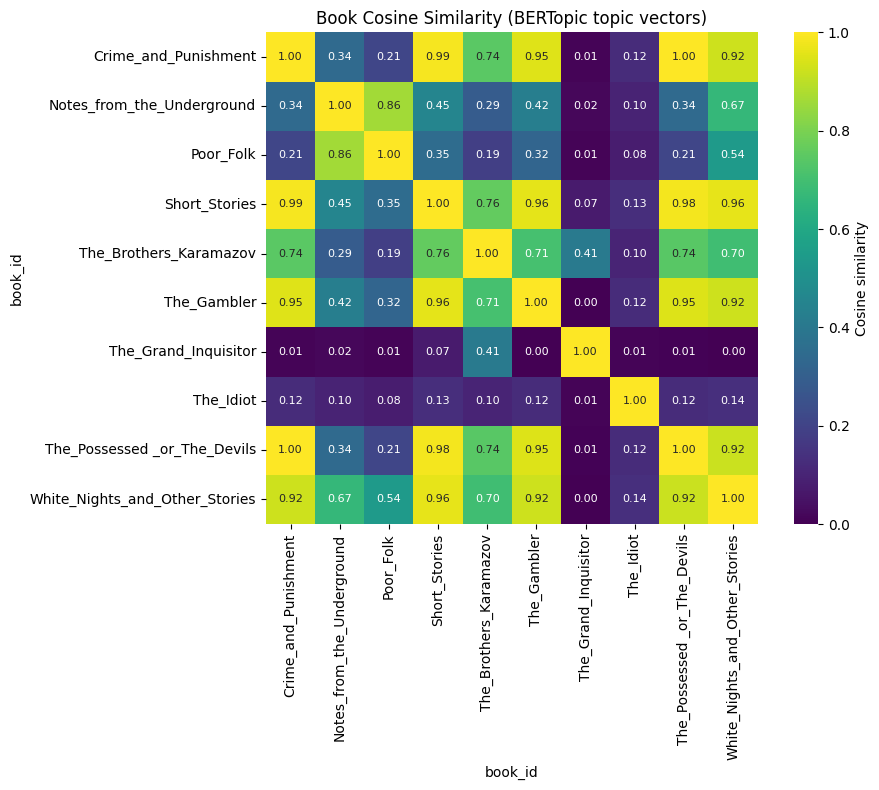

In [27]:
plt.figure(figsize=(10, 8)) # Increased figure size for better visibility
sns.heatmap(
    bert_book_sim,
    cmap="viridis",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cosine similarity"},
    annot=True,        # Display numbers in each cell
    fmt=".2f",         # Format numbers to two decimal places
    annot_kws={"size": 8} # Adjust font size of annotations
)
plt.title("Book Cosine Similarity (BERTopic topic vectors)")
plt.xlabel("book_id")
plt.ylabel("book_id")
plt.tight_layout()
plt.show()

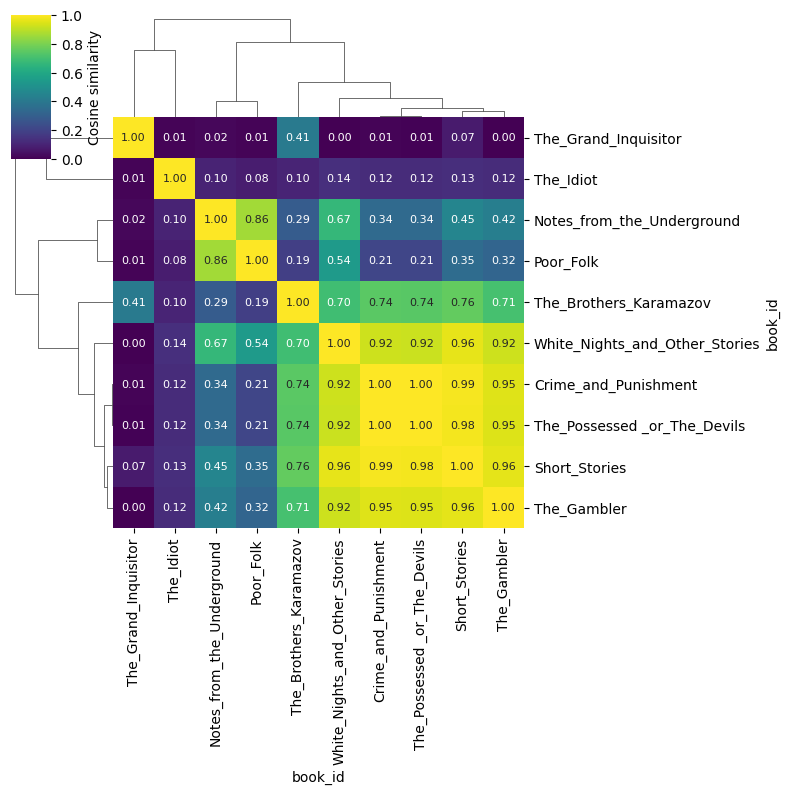

In [32]:
sns.clustermap(
    bert_book_sim,
    cmap="viridis",
    vmin=0, vmax=1,
    figsize=(8, 8),
    cbar_kws={"label": "Cosine similarity"},
    metric="euclidean",   # clustering on similarity matrix itself
    method="average",
    annot=True,        # Display numbers in each cell
    fmt=".2f",         # Format numbers to two decimal places
    annot_kws={"size": 8} # Adjust font size of annotations
)

In [23]:
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# topic ids excluding outlier -1
bert_topic_ids = [t for t in topic_model_bert.get_topic_info().Topic.tolist() if t != -1]

# top words per topic
def bert_top_words(topic_model, topic_ids, topn=10):
    out = []
    for tid in topic_ids:
        out.append([w for w, _ in topic_model.get_topic(tid)[:topn]])
    return out

bert_topic_words_10 = bert_top_words(topic_model_bert, bert_topic_ids, topn=10)

# Tokenise documents with the fitted vectorizer inside BERTopic
bert_vectorizer = topic_model_bert.vectorizer_model
bert_analyzer = bert_vectorizer.build_analyzer()

bert_texts = df_docs["text_bert"].astype(str).tolist()
bert_tokens = [bert_analyzer(t) for t in bert_texts]

bert_dictionary = Dictionary(bert_tokens)
bert_corpus = [bert_dictionary.doc2bow(toks) for toks in bert_tokens]

# Coherence per topic
bert_coh_npmi = CoherenceModel(topics=bert_topic_words_10, texts=bert_tokens,
                               dictionary=bert_dictionary, coherence="c_npmi")
bert_coh_uci  = CoherenceModel(topics=bert_topic_words_10, texts=bert_tokens,
                               dictionary=bert_dictionary, coherence="c_uci")
bert_coh_umass = CoherenceModel(topics=bert_topic_words_10, corpus=bert_corpus,
                                dictionary=bert_dictionary, coherence="u_mass")

bert_quality = pd.DataFrame({
    "topic_id": bert_topic_ids,
    "coh_npmi": bert_coh_npmi.get_coherence_per_topic(),
    "coh_uci": bert_coh_uci.get_coherence_per_topic(),
    "coh_umass": bert_coh_umass.get_coherence_per_topic(),
    "top_words": [", ".join(ws) for ws in bert_topic_words_10]
}).sort_values("coh_npmi", ascending=False)

bert_quality


,topic_id,coh_npmi,coh_uci,coh_umass,top_words
8,8,0.017909,0.125722,-1.790905,"words, without, much, speak, word, believe, sp..."
4,4,0.012336,0.074176,-2.024987,"words, much, keep, tears, course, laughed, lau..."
15,15,0.012302,0.080746,-1.881612,"much, word, understand, mind, feel, thought, q..."
6,6,0.010017,0.077757,-1.795018,"life, mind, understand, become, think, ought, ..."
3,3,0.001160,-0.017674,-1.698221,"father, death, tears, words, feel, seemed, giv..."
2,2,0.000443,-0.021983,-1.484219,"feel, suddenly, word, thought, moment, upon, m..."
12,12,0.000383,-0.005579,-1.544659,"laughed, laughing, came, good, seemed, upon, k..."
1,1,0.000331,-0.016510,-1.562116,"words, laughing, suddenly, much, came, laughed..."
16,16,-0.000928,-0.056483,-1.943125,"father, tears, together, heart, mother, away, ..."
13,13,-0.001586,-0.044843,-2.063847,"kept, get, give, much, although, laughed, thin..."


In [24]:
bert_avg = bert_quality[["coh_umass", "coh_uci", "coh_npmi"]].mean()
print("BERTopic average coherence scores:")
print(bert_avg)

BERTopic average coherence scores:
coh_umass   -1.800541
coh_uci     -0.078193
coh_npmi    -0.001356
dtype: float64


In [25]:
def topic_diversity(topic_words, topn=10):
    words = [w for topic in topic_words for w in topic[:topn]]
    return len(set(words)) / (len(topic_words) * topn)

bert_diversity_10 = topic_diversity(bert_topic_words_10, topn=10)
print("BERTopic topic diversity for top 10 words:", bert_diversity_10)


BERTopic topic diversity for top 10 words: 0.32105263157894737


In [26]:
# 1) Get topic info and exclude outlier topic -1
topic_info = topic_model_bert.get_topic_info()
topic_info_non_out = topic_info[topic_info.Topic != -1].copy()
topic_ids = topic_info_non_out.Topic.tolist()

# 2) Get c-TF-IDF matrix (topics x vocab). Convert to dense array.
# NOTE: c_tf_idf_ rows align with get_topic_info() order in BERTopic.
c_tf_idf = topic_model_bert.c_tf_idf_
A = c_tf_idf.toarray() if hasattr(c_tf_idf, "toarray") else np.asarray(c_tf_idf)

# 3) Drop the row corresponding to outlier topic -1 if it exists in the matrix alignment
# In most BERTopic setups, the first row corresponds to -1 when it's present in topic_info.
# We'll align by using the same ordering as topic_info and filtering.
topic_order = topic_info.Topic.tolist()
keep_mask = [t != -1 for t in topic_order]
A = A[keep_mask, :]

# 4) Convert each row into a probability distribution (smooth + normalise)
eps = 1e-12
A = A + eps
bert_phi = A / A.sum(axis=1, keepdims=True)  # topic-term "probabilities"

# 5) Compute JSD distances
K = bert_phi.shape[0]
bert_jsd = np.zeros((K, K))
for i in range(K):
    for j in range(K):
        bert_jsd[i, j] = jensenshannon(bert_phi[i], bert_phi[j])  # distance in [0, 1]

bert_jsd_df = pd.DataFrame(
    bert_jsd,
    index=[f"topic_{t}" for t in topic_ids],
    columns=[f"topic_{t}" for t in topic_ids]
)

# 6) Top redundant topic pairs = smallest off-diagonal distances
pairs = []
for i in range(K):
    for j in range(i+1, K):
        pairs.append((topic_ids[i], topic_ids[j], bert_jsd[i, j]))
pairs.sort(key=lambda x: x[2])

print("Most similar (potentially redundant) BERTopic topic pairs (smallest JSD distance):")
for a, b, d in pairs[:10]:
    print(f"topic_{a} vs topic_{b}: JSD={d:.4f}")

bert_jsd_df

Most similar (potentially redundant) BERTopic topic pairs (smallest JSD distance):
topic_0 vs topic_2: JSD=0.1303
topic_0 vs topic_1: JSD=0.1324
topic_0 vs topic_4: JSD=0.1397
topic_1 vs topic_2: JSD=0.1671
topic_2 vs topic_4: JSD=0.1798
topic_1 vs topic_4: JSD=0.1808
topic_0 vs topic_7: JSD=0.1945
topic_2 vs topic_3: JSD=0.2003
topic_3 vs topic_4: JSD=0.2043
topic_0 vs topic_3: JSD=0.2064


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
topic_0,0.000000,0.132390,0.130289,0.206447,0.139671,0.219512,0.317382,0.194530,0.234561,0.320302,0.313068,0.423799,0.335927,0.331870,0.468599,0.527308,0.625791,0.608111,0.521911
topic_1,0.132390,0.000000,0.167148,0.230196,0.180846,0.246120,0.317263,0.238227,0.245355,0.335333,0.328992,0.418309,0.367407,0.360532,0.467396,0.532304,0.632930,0.614891,0.532648
topic_2,0.130289,0.167148,0.000000,0.200343,0.179803,0.238525,0.285722,0.235808,0.248842,0.297568,0.324320,0.427110,0.355828,0.345265,0.456504,0.508170,0.620854,0.614262,0.521419
topic_3,0.206447,0.230196,0.200343,0.000000,0.204335,0.232822,0.333354,0.269519,0.262490,0.361898,0.337038,0.428693,0.388792,0.379884,0.475831,0.533773,0.598538,0.640948,0.519633
topic_4,0.139671,0.180846,0.179803,0.204335,0.000000,0.248770,0.337648,0.224271,0.258691,0.364344,0.336061,0.435778,0.365248,0.363159,0.463045,0.533371,0.610205,0.590026,0.535760
topic_5,0.219512,0.246120,0.238525,0.232822,0.248770,0.000000,0.320179,0.285193,0.286619,0.355094,0.379535,0.447976,0.384756,0.396751,0.472482,0.539193,0.636738,0.605286,0.532715
topic_6,0.317382,0.317263,0.285722,0.333354,0.337648,0.320179,0.000000,0.367638,0.298244,0.376251,0.457117,0.447854,0.475564,0.420769,0.427655,0.479626,0.659563,0.579177,0.576240
topic_7,0.194530,0.238227,0.235808,0.269519,0.224271,0.285193,0.367638,0.000000,0.309985,0.389711,0.344957,0.465774,0.368535,0.379566,0.507916,0.543893,0.622223,0.616821,0.541513
topic_8,0.234561,0.245355,0.248842,0.262490,0.258691,0.286619,0.298244,0.309985,0.000000,0.369302,0.374693,0.410196,0.412771,0.383168,0.464721,0.525699,0.652416,0.616758,0.539898
topic_9,0.320302,0.335333,0.297568,0.361898,0.364344,0.355094,0.376251,0.389711,0.369302,0.000000,0.442765,0.457754,0.437948,0.399049,0.506483,0.566180,0.664387,0.658461,0.588388
